## Feature Selection, Data Modeling, and Neural Network
### Remove Null data for first season
### Observe feature correlation
### Train and test model data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler,StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split, cross_validate
from sklearn.metrics import mean_absolute_error

import lightgbm as lgb

import gc

plt.style.use('seaborn-darkgrid')

In [2]:
training_df = pd.read_csv('output/training_df.csv')
training_df.head()

day_of_season   Sea_DRtg  Sea_Opp_3FGM%  Sea_Opp_PF   Sea_Pace  \
0             14        NaN            NaN         NaN        NaN   
1             17  85.500000       0.071000   22.000000  61.800000   
2             20  85.600000       0.202000   19.000000  62.000000   
3             24  90.866667       0.220333   20.666667  65.133333   
4             32  90.450000       0.245250   20.750000  65.375000   

   wt_Sea_ORtg  wt_Sea_Stl%_x  wt_Sea_Ast%  wt_Sea_Opp_Ast%  wt_Sea_Blk%  ...  \
0          NaN            NaN          NaN              NaN          NaN  ...   
1   106.500000       9.700000    59.100000              NaN    10.300000  ...   
2    95.958000       9.826000    54.186000              NaN    11.224000  ...   
3   102.265280      10.252160    60.161760           57.100    11.987840  ...   
4   101.979445      11.846346    59.626882           56.848    10.045054  ...   

   opp_5yr_3PT  opp_5yr_TO  opp_5yr_Win  opp_5yr_Off_Rtg  opp_5yr_Pace  \
0          NaN         NaN          NaN              NaN           NaN   
1          NaN         NaN          NaN              NaN           NaN   
2          NaN         NaN          NaN              NaN           NaN   
3          NaN         NaN          NaN              NaN           NaN   
4          NaN         NaN          NaN              NaN           NaN   

   opp_5yr_Opp_FGM%  opp_5yr_FTM%  opp_5yr_3FGM%  opp_5yr_Stl%  target  
0               NaN           NaN            NaN           NaN      13  
1               NaN           NaN            NaN           NaN      -3  
2               NaN           NaN            NaN           NaN      15  
3               NaN           NaN            NaN           NaN       6  
4               NaN           NaN            NaN           NaN       9  

[5 rows x 57 columns]

In [3]:
# Eliminate games from 2011 due to null values

training_df.isna().sum(axis=1)
print(len(training_df))
training_df = training_df.dropna(axis=0)
print(len(training_df))

with pd.option_context('mode.use_inf_as_na', True):
    training_df = training_df.fillna(0)

106370
84626


In [4]:
print(training_df.shape)

(84626, 57)


In [5]:
y = training_df.target
X = training_df.drop(columns=['target'])

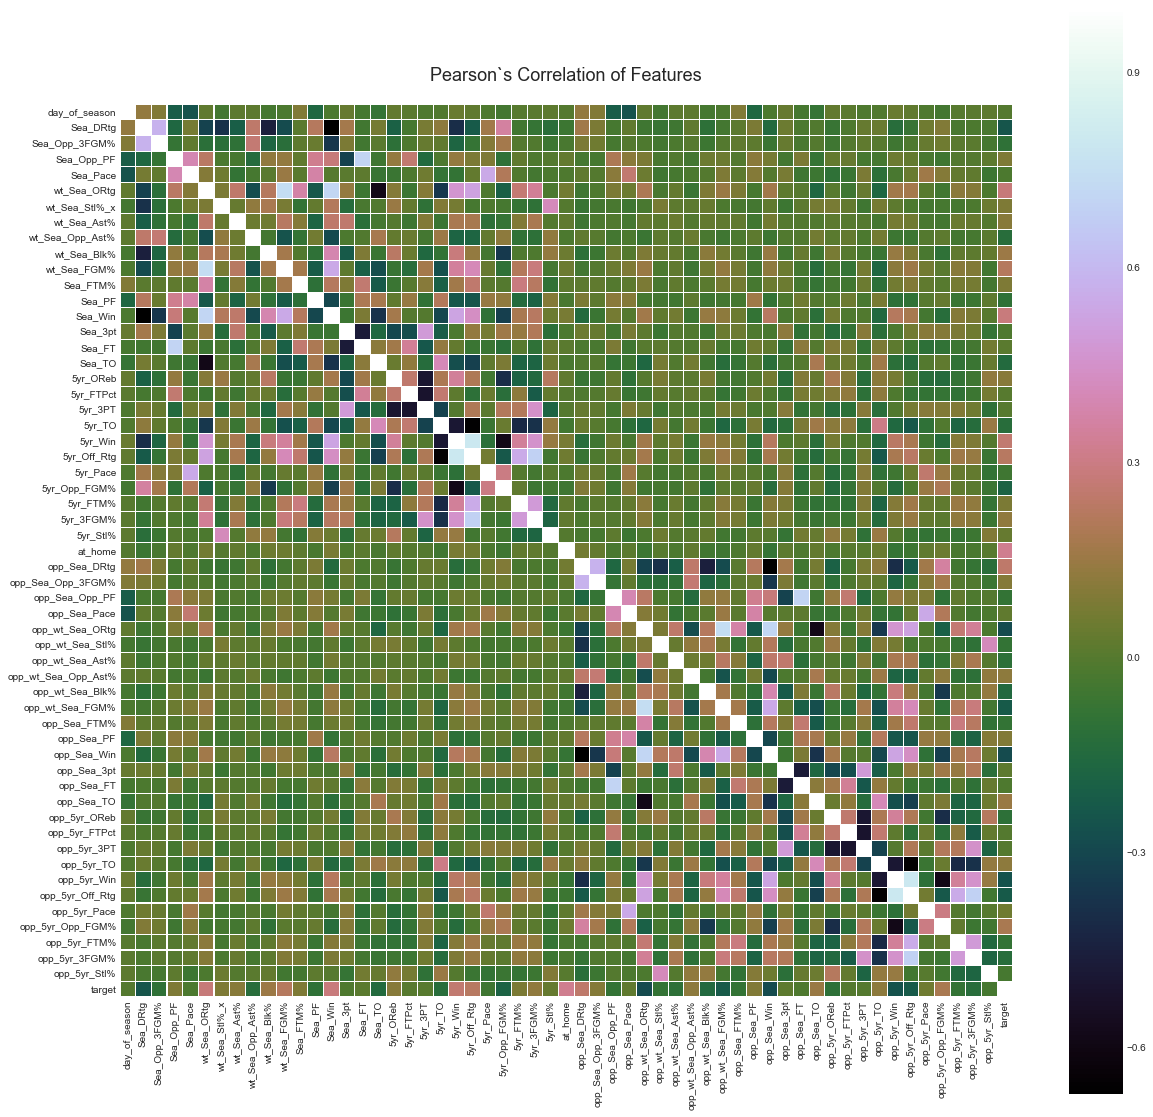

In [6]:
colorpalette = plt.cm.cubehelix
plt.figure(figsize=(20,20))
plt.title('Pearson`s Correlation of Features', y=1.02, size=18)
sns.heatmap(training_df.astype(float).corr(),linewidths=0.15,vmax=1.0, 
            square=True, cmap=colorpalette, linecolor='white', annot=False)

plt.savefig('./figures/pearson_correlation.png')

In [7]:
scaler = StandardScaler()
cat = []
num = [i for i in list(training_df)]

training_df[num] = scaler.fit_transform(training_df[num])

# Utilize LOFO Importance -- https://github.com/aerdem4/lofo-importance

### LOFO (Leave One Feature Out) Importance calculates the importances of a set of features based on a metric of choice, for a model of choice, by iteratively removing each feature from the set, and evaluating the performance of the model, with a validation scheme of choice, based on the chosen metric.

### LOFO first evaluates the performance of the model with all the input features included, then iteratively removes one feature at a time, retrains the model, and evaluates its performance on a validation set. The mean and standard deviation (across the folds) of the importance of each feature is then reported.

In [8]:
from lofo import LOFOImportance, Dataset, plot_importance

# extract a sample of the data
sample_df = training_df.sample(frac=1, random_state=0)

# define the validation scheme
cv = KFold(n_splits=5, shuffle=True, random_state=0)

# define the binary target and the features
dataset = Dataset(df=sample_df, target="target", features=[col for col in training_df.columns if col != "target"])

100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [04:39<00:00,  5.00s/it]


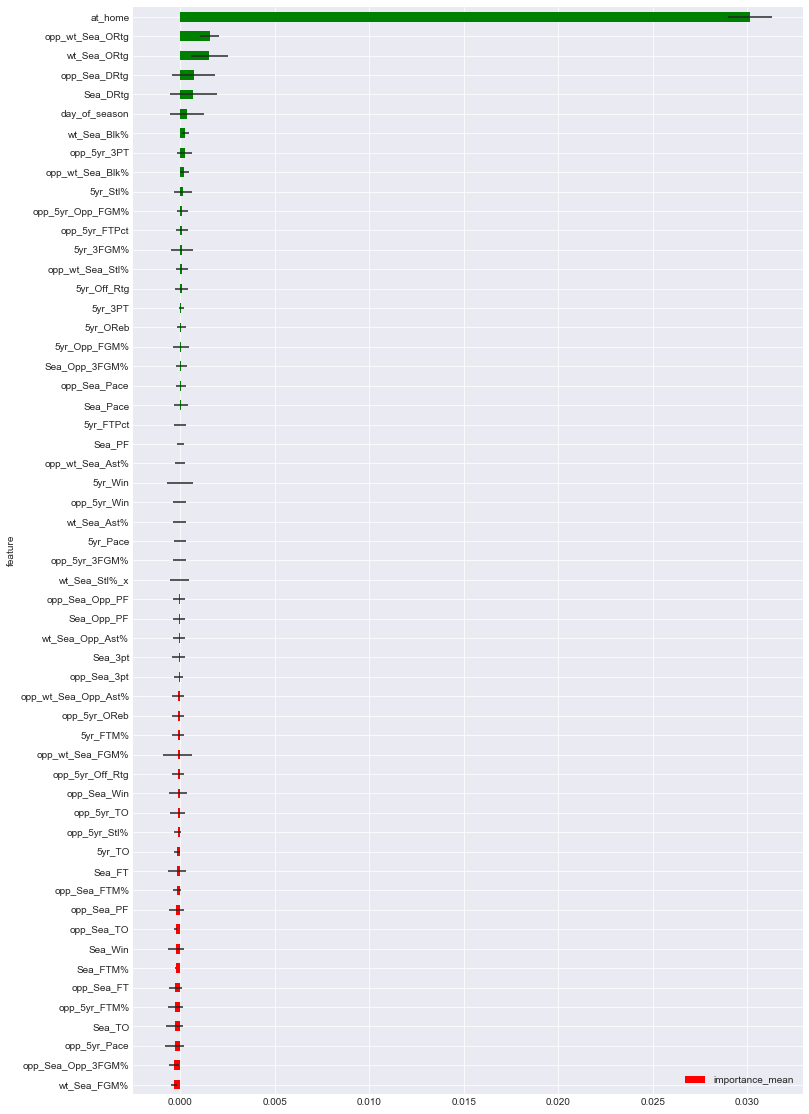

In [9]:
model_lgb = lgb.LGBMRegressor(objective='regression',learning_rate=0.09,importance='gain')

# define the validation scheme and scorer. The default model is LightGBM
lofo_imp = LOFOImportance(dataset, model= model_lgb, cv=cv, scoring="neg_mean_absolute_error")

# get the mean and standard deviation of the importances in pandas format
importance_df = lofo_imp.get_importance()

# plot the means and standard deviations of the importances
plot_importance(importance_df, figsize=(12, 20))


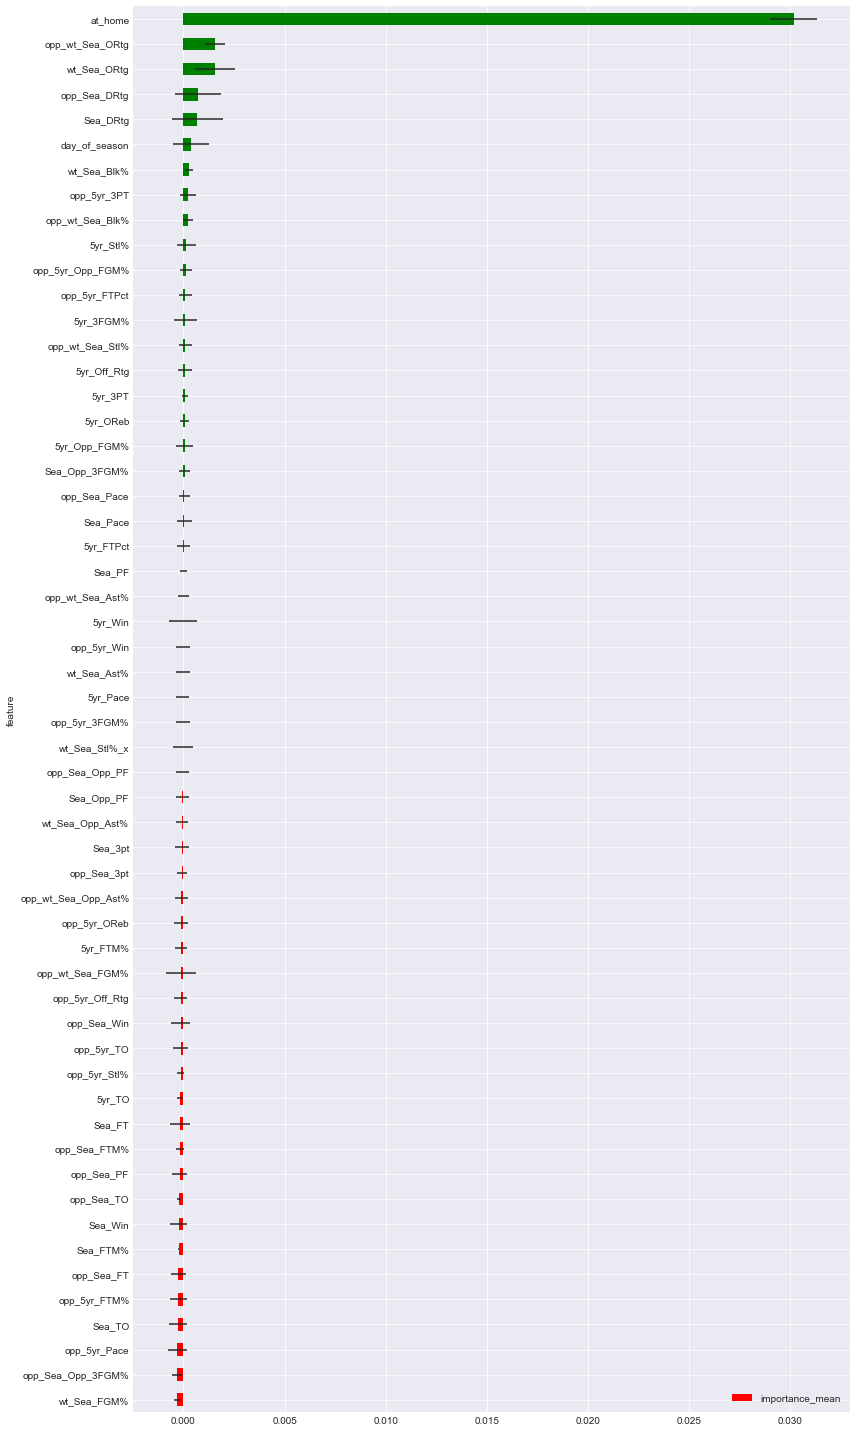

In [10]:
figsize = (12,20)
importance_df["color"] = (importance_df["importance_mean"] > 0).map({True: 'g', False: 'r'})
importance_df.sort_values("importance_mean", inplace=True)
importance_df.plot(x="feature", y="importance_mean", xerr="importance_std", kind='barh', color=importance_df["color"], figsize=figsize)
plt.tight_layout()

plt.savefig('./figures/lofo_importance4.png')

In [11]:
n_folds = 5
feat_names = list(X)

def mae_cv(model, lin_reg=False):

    kf = KFold(n_folds, shuffle=True, random_state=17).get_n_splits(X.values)
    output = cross_validate(model, X.values, y, cv=kf, scoring = 'neg_mean_absolute_error', return_estimator=True)
    all_estimators = []
    for idx,estimator in enumerate(output['estimator']):
        if lin_reg:
            all_estimators.append(list(estimator.coef_))
        else:  
            all_estimators.append(list(estimator.feature_importances_))
    
    all_estimators = pd.DataFrame(all_estimators)
    avg_imp = all_estimators.values.mean(axis=0)
    feature_importances = pd.DataFrame(avg_imp, index = feat_names,
                                       columns=['importance']).sort_values('importance', ascending=False).reset_index()
    
    feature_importances.columns = ['feats','importance']
    return output, feature_importances

Linear Regression score: 9.1135 (0.1409)



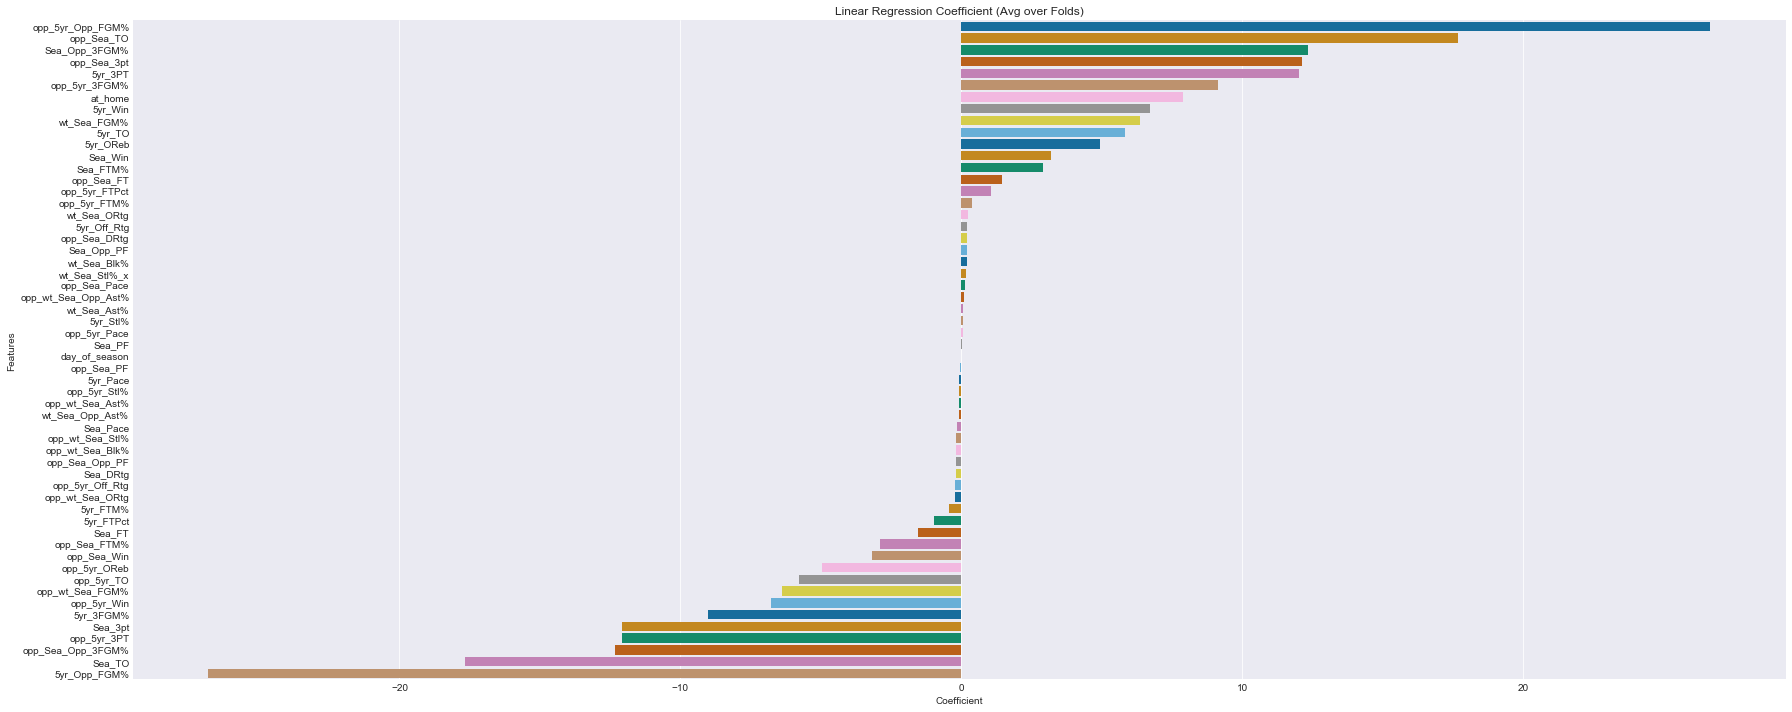

In [12]:
lin_reg = LinearRegression()

output, feat_imp = mae_cv(lin_reg, lin_reg=True)
print("Linear Regression score: {:.4f} ({:.4f})\n" .format(-1*output['test_score'].mean(), output['test_score'].std()))

plt.figure(figsize=(25, 10))

sns.barplot(x="importance", y="feats", data=feat_imp, palette="colorblind")
plt.title('Linear Regression Coefficient (Avg over Folds)')
plt.xlabel('Coefficient')
plt.ylabel('Features')
plt.tight_layout()
plt.savefig('./figures/linreg_importances-03.png')
plt.show()

LGBM score: 9.0311 (0.1431)



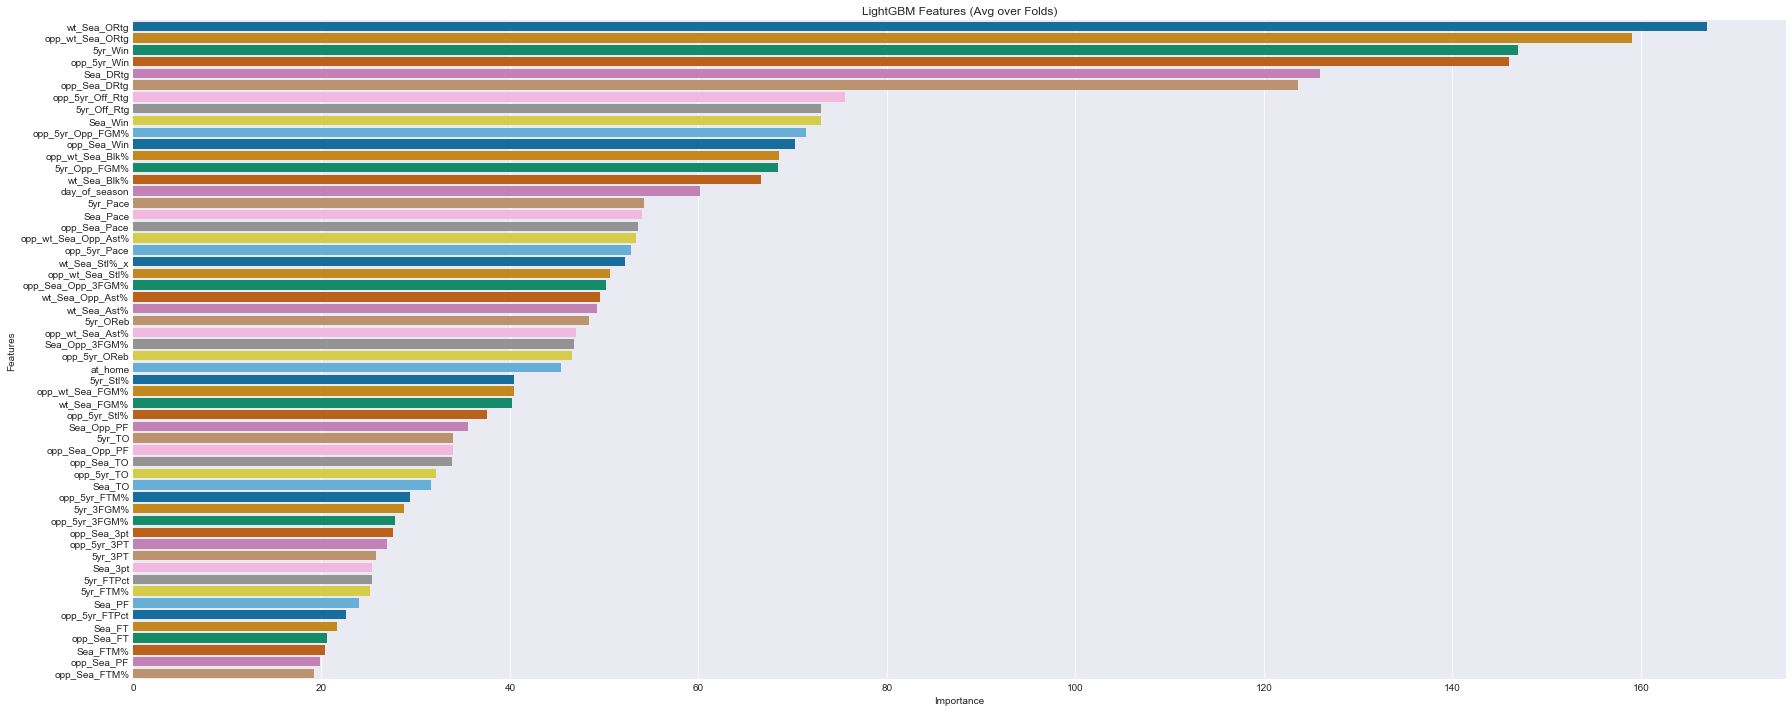

In [13]:
model_lgb = lgb.LGBMRegressor(objective='regression',learning_rate=0.09,importance='gain')

output, feat_imp = mae_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(-1*output['test_score'].mean(), output['test_score'].std()))

plt.figure(figsize=(25, 10))

sns.barplot(x="importance", y="feats", data=feat_imp, palette="colorblind")
plt.title('LightGBM Features (Avg over Folds)')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.savefig('./figures/lgbm_importances-03.png')
plt.show()

In [14]:
print(list(feat_imp.feats))

['wt_Sea_ORtg', 'opp_wt_Sea_ORtg', '5yr_Win', 'opp_5yr_Win', 'Sea_DRtg', 'opp_Sea_DRtg', 'opp_5yr_Off_Rtg', '5yr_Off_Rtg', 'Sea_Win', 'opp_5yr_Opp_FGM%', 'opp_Sea_Win', 'opp_wt_Sea_Blk%', '5yr_Opp_FGM%', 'wt_Sea_Blk%', 'day_of_season', '5yr_Pace', 'Sea_Pace', 'opp_Sea_Pace', 'opp_wt_Sea_Opp_Ast%', 'opp_5yr_Pace', 'wt_Sea_Stl%_x', 'opp_wt_Sea_Stl%', 'opp_Sea_Opp_3FGM%', 'wt_Sea_Opp_Ast%', 'wt_Sea_Ast%', '5yr_OReb', 'opp_wt_Sea_Ast%', 'Sea_Opp_3FGM%', 'opp_5yr_OReb', 'at_home', '5yr_Stl%', 'opp_wt_Sea_FGM%', 'wt_Sea_FGM%', 'opp_5yr_Stl%', 'Sea_Opp_PF', '5yr_TO', 'opp_Sea_Opp_PF', 'opp_Sea_TO', 'opp_5yr_TO', 'Sea_TO', 'opp_5yr_FTM%', '5yr_3FGM%', 'opp_5yr_3FGM%', 'opp_Sea_3pt', 'opp_5yr_3PT', '5yr_3PT', 'Sea_3pt', '5yr_FTPct', '5yr_FTM%', 'Sea_PF', 'opp_5yr_FTPct', 'Sea_FT', 'opp_Sea_FT', 'Sea_FTM%', 'opp_Sea_PF', 'opp_Sea_FTM%']


In [17]:
to_drop = ['Sea_TO','opp_Sea_TO',
           'Sea_FT','opp_Sea_FT',
           'Sea_PF','opp_Sea_PF', 
           'Sea_FTM%', 'opp_Sea_FTM%', 
           '5yr_FTPct', 'opp_5yr_FTPct', 
           '5yr_FTM%', 'opp_5yr_FTM%']

X = X.drop(columns=to_drop)

## Create a Deep Learning Model using Repeated K-Fold cross validator
#### Repeats K-Fold 5 times with different randomization in each repetition. Cross-validator repeats 5 times.

In [19]:
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

Using TensorFlow backend.


In [20]:
# Define the keras model

def get_model():
    model = Sequential()
    model.add(Dense(200, input_dim=X.shape[1], activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(44, activation='relu'))
    model.add(Dense(1, activation='linear'))
    return model

model = get_model()

In [21]:
def train_model(X_train, y_train, X_val, y_val):
    model = get_model()
    model.compile(optimizer='adam', loss='mean_absolute_error')
    er = EarlyStopping(patience=20, min_delta=1e-4, restore_best_weights=True, monitor='val_loss')
    model.fit(X_train, y_train, epochs=200, callbacks=[er], validation_data=[X_val, y_val], batch_size=batch_size)
    return model

In [22]:
X = X.values
y = y.values

In [23]:
X.shape

(84626, 44)

In [24]:
rkf = RepeatedKFold(n_splits=5, n_repeats=5)
batch_size = 64
models = []

for tr_idx, vl_idx in rkf.split(X, y):
    
    x_tr, y_tr = X[tr_idx], y[tr_idx]
    x_vl, y_vl = X[vl_idx], y[vl_idx]
    
    model = train_model(x_tr, y_tr, x_vl, y_vl)
    models.append(model)

Train on 67700 samples, validate on 16926 samples
Epoch 1/200
67700/67700 [==============================] - 3s 45us/step - loss: 10.3830 - val_loss: 9.4179
Epoch 2/200
67700/67700 [==============================] - 3s 39us/step - loss: 9.6320 - val_loss: 9.4028
Epoch 3/200
67700/67700 [==============================] - 3s 40us/step - loss: 9.5135 - val_loss: 9.4631
Epoch 4/200
67700/67700 [==============================] - 3s 40us/step - loss: 9.4715 - val_loss: 9.1244
Epoch 5/200
67700/67700 [==============================] - 3s 40us/step - loss: 9.4256 - val_loss: 9.2283
Epoch 6/200
67700/67700 [==============================] - 3s 40us/step - loss: 9.4249 - val_loss: 9.2617
Epoch 7/200
67700/67700 [==============================] - 3s 40us/step - loss: 9.3956 - val_loss: 9.3591
Epoch 8/200
67700/67700 [==============================] - 3s 40us/step - loss: 9.3837 - val_loss: 9.2222
Epoch 9/200
67700/67700 [==============================] - 3s 40us/step - loss: 9.3467 - val_loss: 9.

67701/67701 [==============================] - 3s 48us/step - loss: 9.2697 - val_loss: 9.2742
Epoch 13/200
67701/67701 [==============================] - 3s 45us/step - loss: 9.2692 - val_loss: 9.4044
Epoch 14/200
67701/67701 [==============================] - 3s 45us/step - loss: 9.2561 - val_loss: 9.5551
Epoch 15/200
67701/67701 [==============================] - 3s 43us/step - loss: 9.2487 - val_loss: 9.3424
Epoch 16/200
67701/67701 [==============================] - 3s 47us/step - loss: 9.2367 - val_loss: 9.5604
Epoch 17/200
67701/67701 [==============================] - 3s 47us/step - loss: 9.2470 - val_loss: 9.3571
Epoch 18/200
67701/67701 [==============================] - 3s 44us/step - loss: 9.2328 - val_loss: 9.3074
Epoch 19/200
67701/67701 [==============================] - 3s 44us/step - loss: 9.2245 - val_loss: 9.2674
Epoch 20/200
67701/67701 [==============================] - 3s 44us/step - loss: 9.2137 - val_loss: 9.4173
Epoch 21/200
67701/67701 [========================

67700/67700 [==============================] - 3s 43us/step - loss: 9.4784 - val_loss: 9.2310
Epoch 5/200
67700/67700 [==============================] - 3s 43us/step - loss: 9.4211 - val_loss: 9.4466
Epoch 6/200
67700/67700 [==============================] - 3s 44us/step - loss: 9.3747 - val_loss: 9.2959
Epoch 7/200
67700/67700 [==============================] - 3s 44us/step - loss: 9.3749 - val_loss: 9.2658
Epoch 8/200
67700/67700 [==============================] - 3s 44us/step - loss: 9.3555 - val_loss: 9.3461
Epoch 9/200
67700/67700 [==============================] - 3s 43us/step - loss: 9.3715 - val_loss: 9.3041
Epoch 10/200
67700/67700 [==============================] - 3s 43us/step - loss: 9.3245 - val_loss: 9.1879
Epoch 11/200
67700/67700 [==============================] - 3s 44us/step - loss: 9.3431 - val_loss: 9.3981
Epoch 12/200
67700/67700 [==============================] - 3s 44us/step - loss: 9.3389 - val_loss: 9.2486
Epoch 13/200
67700/67700 [=============================

Epoch 5/200
67701/67701 [==============================] - 3s 43us/step - loss: 9.4107 - val_loss: 9.2888
Epoch 6/200
67701/67701 [==============================] - 3s 42us/step - loss: 9.4036 - val_loss: 9.1348
Epoch 7/200
67701/67701 [==============================] - 3s 43us/step - loss: 9.3841 - val_loss: 9.4610
Epoch 8/200
67701/67701 [==============================] - 3s 43us/step - loss: 9.3675 - val_loss: 9.3724
Epoch 9/200
67701/67701 [==============================] - 3s 43us/step - loss: 9.3819 - val_loss: 9.2084
Epoch 10/200
67701/67701 [==============================] - 3s 43us/step - loss: 9.3336 - val_loss: 9.1858
Epoch 11/200
67701/67701 [==============================] - 3s 43us/step - loss: 9.3406 - val_loss: 9.3570
Epoch 12/200
67701/67701 [==============================] - 3s 43us/step - loss: 9.3242 - val_loss: 9.2062
Epoch 13/200
67701/67701 [==============================] - 3s 43us/step - loss: 9.2885 - val_loss: 9.1592
Epoch 14/200
67701/67701 [================

67701/67701 [==============================] - 3s 43us/step - loss: 9.1915 - val_loss: 9.3196
Epoch 34/200
67701/67701 [==============================] - 3s 45us/step - loss: 9.1898 - val_loss: 9.3750
Epoch 35/200
67701/67701 [==============================] - 3s 43us/step - loss: 9.1724 - val_loss: 9.5009
Epoch 36/200
67701/67701 [==============================] - 3s 43us/step - loss: 9.1831 - val_loss: 9.3189
Epoch 37/200
67701/67701 [==============================] - 3s 43us/step - loss: 9.1795 - val_loss: 9.2877
Epoch 38/200
67701/67701 [==============================] - 3s 43us/step - loss: 9.1578 - val_loss: 9.3700
Epoch 39/200
67701/67701 [==============================] - 3s 43us/step - loss: 9.1670 - val_loss: 9.5109
Epoch 40/200
67701/67701 [==============================] - 3s 43us/step - loss: 9.1681 - val_loss: 9.4297
Epoch 41/200
67701/67701 [==============================] - 3s 43us/step - loss: 9.1638 - val_loss: 9.4163
Train on 67701 samples, validate on 16925 samples


Epoch 27/200
67700/67700 [==============================] - 3s 43us/step - loss: 9.2192 - val_loss: 9.2764
Epoch 28/200
67700/67700 [==============================] - 3s 44us/step - loss: 9.2184 - val_loss: 9.3064
Epoch 29/200
67700/67700 [==============================] - 3s 43us/step - loss: 9.2098 - val_loss: 9.2564
Epoch 30/200
67700/67700 [==============================] - 3s 44us/step - loss: 9.2163 - val_loss: 9.2380
Epoch 31/200
67700/67700 [==============================] - 3s 44us/step - loss: 9.1999 - val_loss: 9.2028
Epoch 32/200
67700/67700 [==============================] - 3s 44us/step - loss: 9.2169 - val_loss: 9.1729
Epoch 33/200
67700/67700 [==============================] - 3s 43us/step - loss: 9.1931 - val_loss: 9.4573
Epoch 34/200
67700/67700 [==============================] - 3s 44us/step - loss: 9.2078 - val_loss: 9.2267
Epoch 35/200
67700/67700 [==============================] - 3s 44us/step - loss: 9.1774 - val_loss: 9.3098
Epoch 36/200
67700/67700 [===========

Epoch 23/200
67701/67701 [==============================] - 3s 42us/step - loss: 9.2154 - val_loss: 9.4063
Epoch 24/200
67701/67701 [==============================] - 3s 42us/step - loss: 9.1897 - val_loss: 9.1940
Epoch 25/200
67701/67701 [==============================] - 3s 44us/step - loss: 9.2023 - val_loss: 9.2803
Epoch 26/200
67701/67701 [==============================] - 3s 45us/step - loss: 9.2008 - val_loss: 9.3457
Epoch 27/200
67701/67701 [==============================] - 3s 44us/step - loss: 9.2009 - val_loss: 9.5181
Epoch 28/200
67701/67701 [==============================] - 3s 43us/step - loss: 9.1863 - val_loss: 9.3386
Epoch 29/200
67701/67701 [==============================] - 3s 43us/step - loss: 9.2086 - val_loss: 9.3648
Epoch 30/200
67701/67701 [==============================] - 3s 43us/step - loss: 9.1855 - val_loss: 9.3335
Epoch 31/200
67701/67701 [==============================] - 3s 43us/step - loss: 9.1886 - val_loss: 9.2735
Epoch 32/200
67701/67701 [===========

67701/67701 [==============================] - 3s 43us/step - loss: 9.1779 - val_loss: 9.3890
Epoch 34/200
67701/67701 [==============================] - 3s 44us/step - loss: 9.1955 - val_loss: 9.4144
Epoch 35/200
67701/67701 [==============================] - 3s 43us/step - loss: 9.2024 - val_loss: 9.4402
Epoch 36/200
67701/67701 [==============================] - 3s 44us/step - loss: 9.1818 - val_loss: 9.2566
Epoch 37/200
67701/67701 [==============================] - 3s 44us/step - loss: 9.1988 - val_loss: 9.3720
Epoch 38/200
67701/67701 [==============================] - 3s 44us/step - loss: 9.1640 - val_loss: 9.5465
Train on 67700 samples, validate on 16926 samples
Epoch 1/200
67700/67700 [==============================] - 3s 48us/step - loss: 10.3666 - val_loss: 9.4799
Epoch 2/200
67700/67700 [==============================] - 3s 43us/step - loss: 9.6686 - val_loss: 9.2696
Epoch 3/200
67700/67700 [==============================] - 3s 43us/step - loss: 9.5294 - val_loss: 9.1895
Ep

Epoch 37/200
67701/67701 [==============================] - 3s 43us/step - loss: 9.1699 - val_loss: 9.3786
Epoch 38/200
67701/67701 [==============================] - 3s 43us/step - loss: 9.1689 - val_loss: 9.3799
Epoch 39/200
67701/67701 [==============================] - 3s 43us/step - loss: 9.1670 - val_loss: 9.5388
Epoch 40/200
67701/67701 [==============================] - 3s 42us/step - loss: 9.1754 - val_loss: 9.4776
Train on 67701 samples, validate on 16925 samples
Epoch 1/200
67701/67701 [==============================] - 3s 48us/step - loss: 10.3155 - val_loss: 9.5463
Epoch 2/200
67701/67701 [==============================] - 3s 42us/step - loss: 9.6485 - val_loss: 9.4640
Epoch 3/200
67701/67701 [==============================] - 3s 42us/step - loss: 9.5017 - val_loss: 9.3053
Epoch 4/200
67701/67701 [==============================] - 3s 42us/step - loss: 9.4328 - val_loss: 9.3970
Epoch 5/200
67701/67701 [==============================] - 3s 42us/step - loss: 9.4000 - val_loss

67701/67701 [==============================] - 3s 41us/step - loss: 9.6677 - val_loss: 9.3481
Epoch 3/200
67701/67701 [==============================] - 3s 41us/step - loss: 9.5304 - val_loss: 9.2047
Epoch 4/200
67701/67701 [==============================] - 3s 41us/step - loss: 9.4679 - val_loss: 9.2589
Epoch 5/200
67701/67701 [==============================] - 3s 41us/step - loss: 9.4130 - val_loss: 9.3465
Epoch 6/200
67701/67701 [==============================] - 3s 41us/step - loss: 9.4067 - val_loss: 9.0861
Epoch 7/200
67701/67701 [==============================] - 3s 41us/step - loss: 9.3704 - val_loss: 9.1350
Epoch 8/200
67701/67701 [==============================] - 3s 41us/step - loss: 9.3567 - val_loss: 9.1539
Epoch 9/200
67701/67701 [==============================] - 3s 41us/step - loss: 9.3372 - val_loss: 9.3725
Epoch 10/200
67701/67701 [==============================] - 3s 41us/step - loss: 9.3386 - val_loss: 9.1967
Epoch 11/200
67701/67701 [==============================]

Epoch 12/200
67701/67701 [==============================] - 3s 42us/step - loss: 9.3521 - val_loss: 9.2448
Epoch 13/200
67701/67701 [==============================] - 3s 43us/step - loss: 9.3112 - val_loss: 9.2439
Epoch 14/200
67701/67701 [==============================] - 3s 43us/step - loss: 9.3233 - val_loss: 9.4518
Epoch 15/200
67701/67701 [==============================] - 3s 43us/step - loss: 9.3180 - val_loss: 9.5620
Epoch 16/200
67701/67701 [==============================] - 3s 43us/step - loss: 9.3162 - val_loss: 9.1617
Epoch 17/200
67701/67701 [==============================] - 3s 43us/step - loss: 9.2992 - val_loss: 9.1763
Epoch 18/200
67701/67701 [==============================] - 3s 43us/step - loss: 9.2952 - val_loss: 9.2938
Epoch 19/200
67701/67701 [==============================] - 3s 43us/step - loss: 9.2892 - val_loss: 9.2724
Epoch 20/200
67701/67701 [==============================] - 3s 42us/step - loss: 9.2909 - val_loss: 9.4042
Epoch 21/200
67701/67701 [===========

67701/67701 [==============================] - 3s 41us/step - loss: 9.4269 - val_loss: 9.3486
Epoch 6/200
67701/67701 [==============================] - 3s 42us/step - loss: 9.3893 - val_loss: 9.6262
Epoch 7/200
67701/67701 [==============================] - 3s 41us/step - loss: 9.3825 - val_loss: 9.2499
Epoch 8/200
67701/67701 [==============================] - 3s 43us/step - loss: 9.3604 - val_loss: 9.2366
Epoch 9/200
67701/67701 [==============================] - 3s 45us/step - loss: 9.3174 - val_loss: 9.3749
Epoch 10/200
67701/67701 [==============================] - 3s 45us/step - loss: 9.3287 - val_loss: 9.3835
Epoch 11/200
67701/67701 [==============================] - 3s 42us/step - loss: 9.3190 - val_loss: 9.3085
Epoch 12/200
67701/67701 [==============================] - 3s 43us/step - loss: 9.2974 - val_loss: 9.2667
Epoch 13/200
67701/67701 [==============================] - 3s 43us/step - loss: 9.2656 - val_loss: 9.4659
Epoch 14/200
67701/67701 [============================

67701/67701 [==============================] - 3s 43us/step - loss: 9.2007 - val_loss: 9.2417
Epoch 28/200
67701/67701 [==============================] - 3s 43us/step - loss: 9.2178 - val_loss: 9.6256
Epoch 29/200
67701/67701 [==============================] - 3s 43us/step - loss: 9.2158 - val_loss: 9.2443
Epoch 30/200
67701/67701 [==============================] - 3s 43us/step - loss: 9.2011 - val_loss: 9.2208
Epoch 31/200
67701/67701 [==============================] - 3s 43us/step - loss: 9.1992 - val_loss: 9.2835


In [25]:
val_losses = []
for model in models:
    val_losses.append(np.min(model.history.history['val_loss']))

print(np.std(val_losses))
print(np.average(val_losses))

0.057450982004726946
9.152957306273033


In [26]:
model.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_101 (Dense)            (None, 200)               9000      
_________________________________________________________________
dropout_51 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_102 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_52 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_103 (Dense)            (None, 44)                4444      
_________________________________________________________________
dense_104 (Dense)            (None, 1)                 45        
Total params: 33,589
Trainable params: 33,589
Non-trainable params: 0
_________________________________________________

In [27]:
# Save the model
model.save("models/RepeatedKFold_model_trained.h5")